In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle

/Users/michal/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
df = pd.read_csv('./fer2013/fer2013.csv')
df.sample(5)

,emotion,pixels,Usage
7016,3,68 76 65 48 55 57 53 52 54 62 74 100 114 121 1...,Training
30505,4,70 236 243 223 89 243 149 239 95 253 189 81 24...,PublicTest
15386,2,26 33 38 20 5 4 4 7 6 5 7 6 4 5 15 18 17 18 33...,Training
10590,3,213 209 198 119 45 43 75 46 52 33 35 66 46 37 ...,Training
31003,3,173 126 89 111 156 191 159 62 66 145 173 167 1...,PublicTest


In [3]:
def error_rate(pred, target):
    return np.mean(pred!=target)

In [4]:
def classification_rate(p, t):
    return np.mean(p == t)

In [5]:
def ohe(labels):
    ohe_lab = np.zeros((labels.shape[0], len(set(labels))))
    for i in range(len(labels)):
        ohe_lab[i, labels[i]] = 1
    return ohe_lab     

In [6]:
Y_all = df['emotion'].astype(int)
X_all = []
for i in df['pixels']:
    X_all.append([int(p) for p in i.split()])
X_all, Y_all = np.array(X_all), np.array(Y_all)

In [7]:
X = X_all / 255
Y = ohe(Y_all)

In [8]:
print(X.shape)
print(type(X))
print(Y.shape)
print(type(Y))

(35887, 2304)
<class 'numpy.ndarray'>
(35887, 7)
<class 'numpy.ndarray'>


In [9]:
max_iter = 50
print_period = 20
lr = 1e-5
reg = 1e-2

In [10]:
X_train = X[:-1000]
Y_train = Y[:-1000]
X_test = X[-1000:]
Y_test = Y[-1000:]

In [11]:
N, D = X_train.shape
batch_size = 100
num_batches = N//batch_size

In [12]:
# hidden layer1 nodes
M1 = 2000
# hidden layer2 nodes
M2 = 1000
# hidden layer3 nodes
M3 = 500
# output nodes
K = 7
# starting wieghts
W1_init = np.random.randn(D, M1) / np.sqrt(D+M1)
b1_init = np.zeros(M1)
W2_init = np.random.randn(M1, M2) / np.sqrt(M1+M2)
b2_init = np.zeros(M2)
W3_init = np.random.randn(M2, M3) / np.sqrt(M2+M3)
b3_init = np.zeros(M3)
W4_init = np.random.randn(M3, K) / np.sqrt(M3+K)
b4_init = np.zeros(K)

In [13]:
# get TF variables for the inputs, X and targets T
ftX = tf.placeholder(tf.float32, shape=(None, D), name='X')
ftT = tf.placeholder(tf.float32, shape=(None, K), name='T')

In [14]:
# get TF variables wieghts and biases
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))
W4 = tf.Variable(W4_init.astype(np.float32))
b4 = tf.Variable(b4_init.astype(np.float32))

In [15]:
Z1 = tf.nn.relu(tf.matmul(ftX, W1)+b1)
Z2 = tf.nn.relu(tf.matmul(Z1, W2)+b2)
Z3 = tf.nn.relu(tf.matmul(Z2, W3)+b3)
Yish = tf.matmul(Z3, W4)+b4

In [16]:
# params = list of weights and biases
# rcost = reg*sum([tf.nn.l2_loss(p) for p in params])
rcost = reg*sum([tf.nn.l2_loss(W1), tf.nn.l2_loss(b1), 
                 tf.nn.l2_loss(W2), tf.nn.l2_loss(b2), 
                 tf.nn.l2_loss(W3), tf.nn.l2_loss(b3),
                 tf.nn.l2_loss(W4), tf.nn.l2_loss(b4)])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=ftT, logits=Yish)) + rcost

In [17]:
pred = tf.argmax(Yish, 1)

In [18]:
train_op = tf.train.RMSPropOptimizer(lr, decay=0.999, momentum=0.99).minimize(cost)

In [19]:
LL = []
error = []
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(max_iter):
        X_train, Y_train = shuffle(X_train, Y_train)
        for j in range(num_batches):
            X_batch = X_train[(j*batch_size):(j*batch_size+batch_size)]
            Y_batch = Y_train[(j*batch_size):(j*batch_size+batch_size)]
        
            sess.run(train_op, feed_dict = {ftX: X_batch, ftT: Y_batch})
            if j % print_period == 0:
                cost_val = sess.run(cost, feed_dict={ftX: X_test, ftT: Y_test})
                pred_val = sess.run(pred, feed_dict={ftX: X_test})
                err = error_rate(pred_val, Y_test.argmax(axis = 1))
                print(i,j,cost_val,err)
                LL.append(cost_val)
                error.append(err)

0 0 33.775375 0.866
0 20 32.438053 0.817
0 40 31.518026 0.806
0 60 31.849277 0.796
0 80 31.273302 0.83
0 100 31.229807 0.752
0 120 31.264122 0.803
0 140 31.025484 0.773
0 160 30.85047 0.754
0 180 30.965254 0.721
0 200 30.766743 0.712
0 220 30.805368 0.752
0 240 30.772736 0.713
0 260 30.730696 0.703
0 280 30.707132 0.731
0 300 30.639082 0.678
0 320 30.629025 0.692
0 340 30.645672 0.709
1 0 30.615503 0.685
1 20 30.571913 0.678
1 40 30.575115 0.667
1 60 30.544838 0.701
1 80 30.520174 0.672
1 100 30.515411 0.676
1 120 30.48205 0.689
1 140 30.449564 0.668
1 160 30.449167 0.67
1 180 30.416603 0.658
1 200 30.399391 0.661
1 220 30.38458 0.672
1 240 30.375088 0.656
1 260 30.35256 0.668
1 280 30.33625 0.654
1 300 30.324583 0.64
1 320 30.314249 0.669
1 340 30.278831 0.642
2 0 30.276783 0.633
2 20 30.269808 0.646
2 40 30.222578 0.628
2 60 30.224907 0.638
2 80 30.220062 0.658
2 100 30.185936 0.63
2 120 30.198055 0.657
2 140 30.164509 0.657
2 160 30.144855 0.639
2 180 30.128166 0.651
2 200 30.095346

20 300 8.71583 0.642
20 320 8.596793 0.596
20 340 8.499005 0.581
21 0 8.464237 0.617
21 20 8.359986 0.621
21 40 8.261289 0.61
21 60 8.208227 0.622
21 80 8.099286 0.633
21 100 7.9676166 0.624
21 120 7.890125 0.632
21 140 7.757967 0.623
21 160 7.6534796 0.61
21 180 7.5843687 0.631
21 200 7.471941 0.602
21 220 7.3576593 0.602
21 240 7.2543025 0.607
21 260 7.178312 0.622
21 280 7.1130867 0.651
21 300 7.0098014 0.609
21 320 6.8842945 0.613
21 340 6.811343 0.617
22 0 6.7784376 0.621
22 20 6.711384 0.624
22 40 6.5792837 0.612
22 60 6.495098 0.62
22 80 6.3903675 0.578
22 100 6.335024 0.593
22 120 6.288752 0.641
22 140 6.186455 0.625
22 160 6.058958 0.627
22 180 5.9570866 0.587
22 200 5.890994 0.611
22 220 5.861554 0.653
22 240 5.7667456 0.643
22 260 5.6714845 0.633
22 280 5.563301 0.606
22 300 5.482925 0.597
22 320 5.394086 0.604
22 340 5.33621 0.617
23 0 5.342638 0.638
23 20 5.2736177 0.649
23 40 5.1671233 0.632
23 60 5.1234865 0.652
23 80 5.047913 0.626
23 100 5.004253 0.644
23 120 4.926471 

41 100 1.7239615 0.67
41 120 1.7227845 0.645
41 140 1.711555 0.642
41 160 1.7148079 0.659
41 180 1.7182707 0.653
41 200 1.7256765 0.664
41 220 1.7279979 0.669
41 240 1.7248054 0.64
41 260 1.7267742 0.665
41 280 1.7408773 0.649
41 300 1.7285817 0.679
41 320 1.7255048 0.644
41 340 1.7131011 0.661
42 0 1.7246568 0.671
42 20 1.7238295 0.645
42 40 1.7247277 0.643
42 60 1.7384183 0.669
42 80 1.7533406 0.664
42 100 1.733578 0.655
42 120 1.7544459 0.694
42 140 1.7340592 0.666
42 160 1.7422063 0.676
42 180 1.7338122 0.676
42 200 1.7281383 0.667
42 220 1.745163 0.684
42 240 1.7314198 0.653
42 260 1.7333627 0.661
42 280 1.74213 0.684
42 300 1.7223235 0.645
42 320 1.727898 0.665
42 340 1.7259285 0.664
43 0 1.717452 0.649
43 20 1.7394075 0.665
43 40 1.7335039 0.688
43 60 1.7333472 0.645
43 80 1.74111 0.677
43 100 1.783982 0.694
43 120 1.7434539 0.664
43 140 1.7281823 0.661
43 160 1.7276971 0.662
43 180 1.7254826 0.664
43 200 1.7244744 0.654
43 220 1.735903 0.641
43 240 1.7101948 0.65
43 260 1.73114

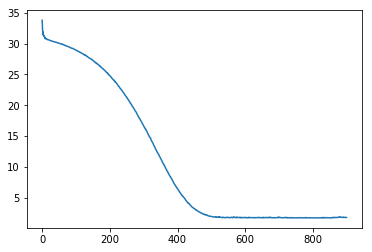

In [20]:
plt.plot(LL)
plt.show()

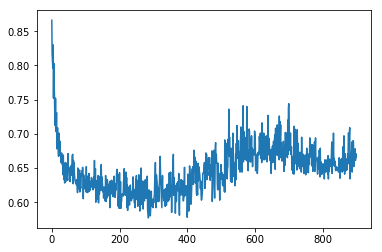

In [21]:
plt.plot(error)
plt.show()